<a href="https://colab.research.google.com/github/A-Wadhwani/ME498-Project/blob/main/07_Long_Short_Term_Memory_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Open drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import tensorflow as tf
import pandas as pd
import random
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import r2_score, mean_squared_log_error, mean_squared_error

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))  

Num GPUs Available:  1


In [ ]:
# To build a Feedforward Neural Network
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import regularizers
from sklearn import preprocessing

In [ ]:
# Reading training and testing dataset files
df1 = pd.read_csv("drive/My Drive/ASHRAE_DATA/modified_data.csv", index_col=0)

le = LabelEncoder()
le.fit(df1['primary_use'])
print(le.classes_)
df1['primary_use'] = le.transform(df1['primary_use'])

X = df1.drop(["meter_reading", "date_time"], axis=1)
y = df1["meter_reading"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


['Education' 'Entertainment/public assembly' 'Food sales and service'
 'Healthcare' 'Lodging/residential' 'Manufacturing/industrial' 'Office'
 'Other' 'Parking' 'Public services' 'Religious worship' 'Retail'
 'Services' 'Technology/science' 'Utility' 'Warehouse/storage']


In [ ]:
# Scaling data
from sklearn.preprocessing import StandardScaler
x_scaler = StandardScaler() 
y_scaler = StandardScaler()

x_train_scaled = x_scaler.fit_transform(x_train)

x_test_scaled = x_scaler.fit_transform(x_test)

In [ ]:
model = Sequential()
model.add(LSTM(16,return_sequences=True, input_shape=(None,x_train.shape[-1])))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(LSTM(128,return_sequences=False))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(1))

model.summary()

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_62 (LSTM)               (None, None, 16)          2240      
_________________________________________________________________
dropout_26 (Dropout)         (None, None, 16)          0         
_________________________________________________________________
batch_normalization_55 (Batc (None, None, 16)          64        
_________________________________________________________________
lstm_63 (LSTM)               (None, 128)               74240     
_________________________________________________________________
dropout_27 (Dropout)         (None, 128)               0         
_________________________________________________________________
batch_normalization_56 (Batc (None, 128)               512       
_________________________________________________________________
dense_24 (Dense)             (None, 1)               

In [ ]:
opt = keras.optimizers.Adam(learning_rate = 0.05)
model.compile(optimizer=opt, loss='mse', metrics=['mse', 'mae'])

#Reduce Learning rate on Plateau 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, verbose = 1)

#Earlystopping callback
early_stop = EarlyStopping(monitor ='val_loss', min_delta= 1e-3, patience = 50, verbose = 1, restore_best_weights=True)

# Reshaping the data
x_copy = x_train_scaled[:]
x_copy = x_copy.reshape((x_copy.shape[0],1,x_copy.shape[-1]))
y_copy = np.log1p(y_train)

x_val = x_test_scaled[:]
x_val = x_val.reshape((x_val.shape[0],1,x_val.shape[-1]))
y_val = np.log1p(y_test)

history = model.fit(x_copy, y_copy, callbacks = [early_stop, reduce_lr], validation_data=(x_val, y_val), epochs=400, batch_size=1000, verbose=1)

Epoch 1/400
1025/1025 [==============================] - 11s 8ms/step - loss: 2.0491 - mse: 2.0491 - mae: 0.9439 - val_loss: 0.4232 - val_mse: 0.4232 - val_mae: 0.4463
Epoch 2/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.5988 - mse: 0.5988 - mae: 0.5420 - val_loss: 0.4144 - val_mse: 0.4144 - val_mae: 0.4157
Epoch 3/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.5547 - mse: 0.5547 - mae: 0.5205 - val_loss: 0.5839 - val_mse: 0.5839 - val_mae: 0.5521
Epoch 4/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.5285 - mse: 0.5285 - mae: 0.5071 - val_loss: 0.3709 - val_mse: 0.3709 - val_mae: 0.3843
Epoch 5/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.5318 - mse: 0.5318 - mae: 0.5067 - val_loss: 0.5098 - val_mse: 0.5098 - val_mae: 0.5287
Epoch 6/400
1025/1025 [==============================] - 7s 7ms/step - loss: 0.5382 - mse: 0.5382 - mae: 0.5109 - val_loss: 0.4311 - val_mse: 0.4311 - val_mae: 0.44

In [ ]:
# Make predictions
start_time = time.time()
y_predict = np.expm1(model.predict(x_val))
end_time = time.time()
print("Prediction Time: ", end_time-start_time, " seconds")

Prediction Time:  23.871355533599854  seconds


In [ ]:
# Evaluate accuracy
print("MSE: ", mean_squared_error(np.expm1(y_val), y_predict))
print("R^2 Score: ", r2_score(np.expm1(y_val), y_predict))

MSE:  12464.764730915944
R^2 Score:  0.8520466028827931


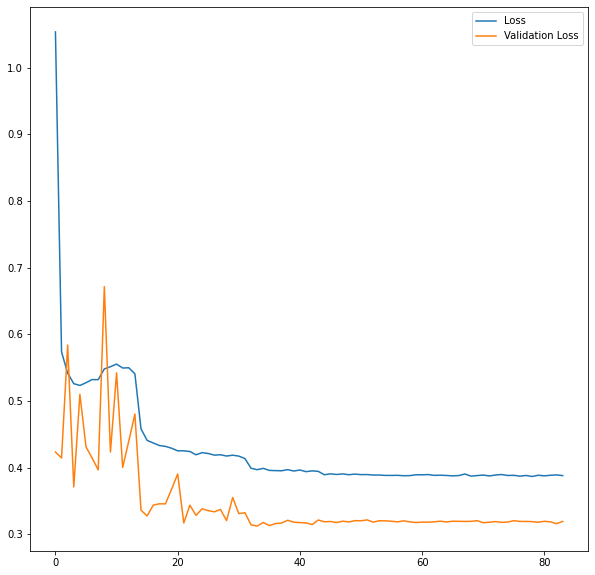

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
model.save("LSTM.h5")

In [ ]:
plt.show()